In [2]:
import os
import cv2
import numpy as np
import torch

def load_image(image_path):
    # Load image using OpenCV
    image = cv2.imread(image_path)
    # Convert image from BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def resize_image(image, target_size):
    # Resize image to target size
    resized_image = cv2.resize(image, target_size)
    return resized_image

def normalize_image(image):
    # Convert pixel values to float and normalize to range [0, 1]
    normalized_image = image.astype(np.float32) / 255.0
    return normalized_image

def preprocess_image(image_path, target_size, save_path=None):
    # Load, resize, and normalize image
    image = load_image(image_path)
    image = resize_image(image, target_size)
    image = normalize_image(image)
    # Convert image to tensor
    image_tensor = torch.tensor(image.transpose(2, 0, 1), dtype=torch.float32)
    
    # Save preprocessed image if save_path is provided
    if save_path:
        save_dir = os.path.dirname(save_path)
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        cv2.imwrite(save_path, cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2BGR))
        return image_tensor

def preprocess_dataset(dataset_path, target_size, save_dir=None):
    dataset_images = []
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            # Check if file is an image
            if file.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
                image_path = os.path.join(root, file)
                # Define save path if save_dir is provided
                save_path = os.path.join(save_dir, file) if save_dir else None
                # Preprocess image and add to list
                image_tensor = preprocess_image(image_path, target_size, save_path)
                dataset_images.append(image_tensor)
    return dataset_images

# Paths to COCO2017 and Painter by Numbers datasets
coco_dataset_path = "C:/Users/srini/Downloads/archive (8)/static_art/"
painter_dataset_path = "C:/Users/srini/Downloads/archive (8)/abstract_art/"
target_size = (256, 256)  # Example target size

# Directory to save preprocessed images
save_coco_dir = "C:/Users/srini/Downloads/preprocessed/coco/"
save_painter_dir = "C:/Users/srini/Downloads/preprocessed/painter/"

# Preprocess COCO2017 dataset
coco_images = preprocess_dataset(coco_dataset_path, target_size, save_coco_dir)
print("Number of COCO2017 images:", len(coco_images))

# Preprocess Painter by Numbers dataset
painter_images = preprocess_dataset(painter_dataset_path, target_size, save_painter_dir)
print("Number of Painter by Numbers images:", len(painter_images))


Number of COCO2017 images: 155
Number of Painter by Numbers images: 24


Preprocessed COCO2017 images:


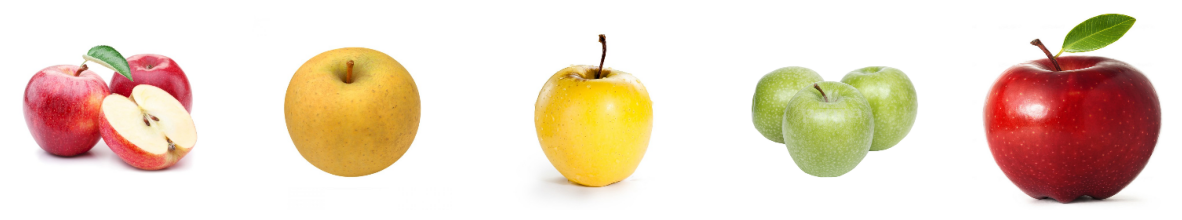

Preprocessed Painter by Numbers images:


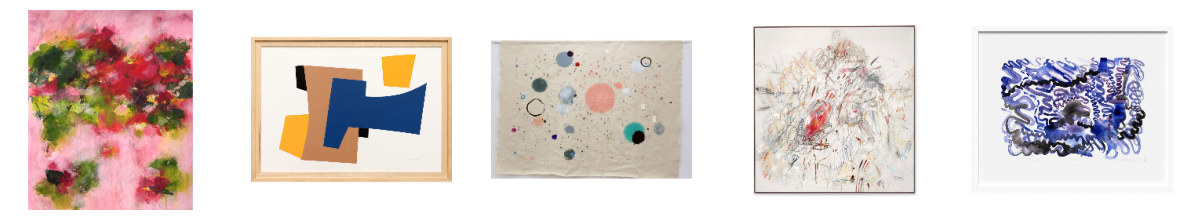

In [3]:
import matplotlib.pyplot as plt

def show_images(images, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        axes[i].imshow(images[i].permute(1, 2, 0))
        axes[i].axis("off")
    plt.show()

# Show preprocessed COCO2017 images
print("Preprocessed COCO2017 images:")
show_images(coco_images)

# Show preprocessed Painter by Numbers images
print("Preprocessed Painter by Numbers images:")
show_images(painter_images)


In [4]:
import torch
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_and_preprocess_image(image_path, image_size):
    image = Image.open(image_path)
    # Convert RGBA image to RGB
    if image.mode == 'RGBA':
        image = image.convert('RGB')
    preprocess = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])
    return preprocess(image).unsqueeze(0).to(device)

# Load the pre-trained ResNet50 model
def load_resnet():
    resnet = models.resnet50(pretrained=True).to(device).eval()
    # Freeze all ResNet parameters since we're only using it for feature extraction
    for param in resnet.parameters():
        param.requires_grad_(False)
    return resnet

def extract_features(image, model, layers=None):
    if layers is None:
        layers = {
            'conv1': 'conv1',
            'layer1': 'layer1',
            'layer2': 'layer2',
            'layer3': 'layer3',
            'layer4': 'layer4',
        }
    features = {}
    x = image
    for name, module in model._modules.items():
        if name == 'fc':
            break  # Stop extraction at fully connected layer
        x = module(x)
        if name in layers.values():
            features[name] = x
    return features

# Compute the content loss
def content_loss(content_features, target_features):
    return torch.mean((content_features['layer4'] - target_features['layer4']) ** 2)

# Compute the Gram matrix of a tensor
def gram_matrix(tensor):
    _, c, h, w = tensor.size()
    tensor = tensor.view(c, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram.div(c * h * w)

# Compute the style loss
def style_loss(style_features, target_features):
    style_loss = 0
    for layer in style_features:
        style_gram = gram_matrix(style_features[layer])
        target_gram = gram_matrix(target_features[layer])
        layer_style_loss = torch.mean((style_gram - target_gram) ** 2)
        style_loss += layer_style_loss
    return style_loss

# Initialize the generated image as a copy of the content image
def initialize_generated_image(content_image):
    return content_image.clone().requires_grad_(True)

def neural_style_transfer(content_image_path, style_image_path, image_size, num_steps=1000, style_weight=1000000, content_weight=1):
    # Load and preprocess content and style images
    content_image = load_and_preprocess_image(content_image_path, image_size)
    style_image = load_and_preprocess_image(style_image_path, image_size)
    
    # Load ResNet model
    resnet = load_resnet()
    
    # Extract features from content and style images
    content_features = extract_features(content_image, resnet)
    style_features = extract_features(style_image, resnet)
    
    # Initialize generated image
    generated_image = initialize_generated_image(content_image)
    
    # Define optimizer
    optimizer = optim.Adam([generated_image], lr=0.01)
    
    # Lists to store content and style losses
    content_losses = []
    style_losses = []
    
    # Main optimization loop
    for i in range(num_steps):
        # Extract features from generated image
        generated_features = extract_features(generated_image, resnet)
        
        # Compute content and style losses
        c_loss = content_loss(content_features, generated_features)
        s_loss = style_loss(style_features, generated_features)
        
        # Append losses to lists
        content_losses.append(c_loss.item())
        style_losses.append(s_loss.item())
        
        # Compute total loss
        total_loss = content_weight * c_loss + style_weight * s_loss
        
        # Update the generated image
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        # Print progress
        if i % 100 == 0:
            print(f'Step [{i}/{num_steps}], Content Loss: {c_loss.item():.4f}, Style Loss: {s_loss.item():.4f}')
    
    return generated_image.detach().cpu(), content_losses, style_losses


# Example usage
content_image_path = "C:/Users/srini/Downloads/archive (8)/static_art/vase23.png"
style_image_path = "C:/Users/srini/Downloads/archive (8)/abstract_art/Sean Wang_A Resplendent Golden Sky.jpg"
image_size = 512
output_image, content_losses, style_losses = neural_style_transfer(content_image_path, style_image_path, image_size)


C:\Users\srini\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\srini\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Step [0/1000], Content Loss: 0.0000, Style Loss: 0.0000


In [1]:
import torch
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_and_preprocess_image(image_path, image_size):
    image = Image.open(image_path)
    # Convert RGBA image to RGB
    if image.mode == 'RGBA':
        image = image.convert('RGB')
    preprocess = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])
    return preprocess(image).unsqueeze(0).to(device)

# Load the pre-trained ResNet50 model
def load_resnet():
    resnet = models.resnet50(pretrained=True).to(device).eval()
    # Freeze all ResNet parameters since we're only using it for feature extraction
    for param in resnet.parameters():
        param.requires_grad_(False)
    return resnet

def extract_features(image, model, layers=None):
    if layers is None:
        layers = {
            'conv1': 'conv1',
            'layer1': 'layer1',
            'layer2': 'layer2',
            'layer3': 'layer3',
            'layer4': 'layer4',
        }
    features = {}
    x = image
    for name, module in model._modules.items():
        if name == 'fc':
            break  # Stop extraction at fully connected layer
        x = module(x)
        if name in layers.values():
            features[name] = x
    return features

# Compute the content loss
def content_loss(content_features, target_features):
    return torch.mean((content_features['layer4'] - target_features['layer4']) ** 2)

# Compute the Gram matrix of a tensor
def gram_matrix(tensor):
    _, c, h, w = tensor.size()
    tensor = tensor.view(c, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram.div(c * h * w)

# Compute the style loss
def style_loss(style_features, target_features):
    style_loss = 0
    for layer in style_features:
        style_gram = gram_matrix(style_features[layer])
        target_gram = gram_matrix(target_features[layer])
        layer_style_loss = torch.mean((style_gram - target_gram) ** 2)
        style_loss += layer_style_loss
    return style_loss

# Initialize the generated image as a copy of the content image
def initialize_generated_image(content_image):
    return content_image.clone().requires_grad_(True)

def neural_style_transfer(content_image_path, style_image_path, image_size, num_steps=1000, style_weight=1000000, content_weight=1):
    # Load and preprocess content and style images
    content_image = load_and_preprocess_image(content_image_path, image_size)
    style_image = load_and_preprocess_image(style_image_path, image_size)
    
    # Load ResNet model
    resnet = load_resnet()
    
    # Extract features from content and style images
    content_features = extract_features(content_image, resnet)
    style_features = extract_features(style_image, resnet)
    
    # Initialize generated image
    generated_image = initialize_generated_image(content_image)
    
    # Define optimizer
    optimizer = optim.Adam([generated_image], lr=0.01)
    
    # Lists to store content and style losses
    content_losses = []
    style_losses = []
    
    # Main optimization loop
    for i in range(num_steps):
        # Extract features from generated image
        generated_features = extract_features(generated_image, resnet)
        
        # Compute content and style losses
        c_loss = content_loss(content_features, generated_features)
        s_loss = style_loss(style_features, generated_features)
        
        # Append losses to lists
        content_losses.append(c_loss.item())
        style_losses.append(s_loss.item())
        
        # Compute total loss
        total_loss = content_weight * c_loss + style_weight * s_loss
        
        # Update the generated image
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        # Print progress
        if i % 100 == 0:
            print(f'Step [{i}/{num_steps}], Content Loss: {c_loss.item():.4f}, Style Loss: {s_loss.item():.4f}')
    
    # Compute final losses and Gram matrix
    final_generated_features = extract_features(generated_image, resnet)
    final_content_loss = content_loss(content_features, final_generated_features)
    final_style_loss = style_loss(style_features, final_generated_features)
    final_style_gram = {layer: gram_matrix(style_features[layer]) for layer in style_features}
    
    # Print final losses and Gram matrix
    print("Final Style Loss:", final_style_loss.item())
    print("Final Content Loss:", final_content_loss.item())
    print("Final Gram Matrix (Style):")
    for layer, gram in final_style_gram.items():
        print(layer, ":", gram)
    
    return generated_image.detach().cpu(), content_losses, style_losses

# Example usage
content_image_path = "C:/Users/srini/Downloads/archive (8)/static_art/vase23.png"
style_image_path = "C:/Users/srini/Downloads/archive (8)/abstract_art/Sean Wang_A Resplendent Golden Sky.jpg"
image_size = 512
output_image, content_losses, style_losses = neural_style_transfer(content_image_path, style_image_path, image_size)


C:\Users\srini\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\srini\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Step [0/1000], Content Loss: 0.0000, Style Loss: 0.0000
Step [100/1000], Content Loss: 0.0049, Style Loss: 0.0000
Step [200/1000], Content Loss: 0.0052, Style Loss: 0.0000
Step [300/1000], Content Loss: 0.0039, Style Loss: 0.0000
Step [400/1000], Content Loss: 0.0033, Style Loss: 0.0000
Step [500/1000], Content Loss: 0.0034, Style Loss: 0.0000
Step [600/1000], Content Loss: 0.0077, Style Loss: 0.0000
Step [700/1000], Content Loss: 0.0032, Style Loss: 0.0000
Step [800/1000], Content Loss: 0.0044, Style Loss: 0.0000
Step [900/1000], Content Loss: 0.0037, Style Loss: 0.0000
Final Style Loss: 9.661127897686583e-09
Final Content Loss: 0.0031143866945058107
Final Gram Matrix (Style):
conv1 : tensor([[ 0.0007, -0.0002,  0.0016,  ...,  0.0002,  0.0023, -0.0001],
        [-0.0002,  0.0014, -0.0016,  ..., -0.0007, -0.0089,  0.0003],
        [ 0.0016, -0.0016,  0.0151,  ...,  0.0022,  0.0202, -0.0010],
        ...,
        [ 0.0002, -0.0007,  0.0022,  ...,  0.0010,  0.0058, -0.0002],
        [ 0.

In [1]:
import torch
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_and_preprocess_image(image_path, image_size):
    image = Image.open(image_path)
    # Convert RGBA image to RGB
    if image.mode == 'RGBA':
        image = image.convert('RGB')
    preprocess = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])
    return preprocess(image).unsqueeze(0).to(device)

# Load the pre-trained ResNet50 model
def load_resnet():
    resnet = models.resnet50(pretrained=True).to(device).eval()
    # Freeze all ResNet parameters since we're only using it for feature extraction
    for param in resnet.parameters():
        param.requires_grad_(False)
    return resnet

def extract_features(image, model, layers=None):
    if layers is None:
        layers = {
            'conv1': 'conv1',
            'layer1': 'layer1',
            'layer2': 'layer2',
            'layer3': 'layer3',
            'layer4': 'layer4',
        }
    features = {}
    x = image
    for name, module in model._modules.items():
        if name == 'fc':
            break  # Stop extraction at fully connected layer
        x = module(x)
        if name in layers.values():
            features[name] = x
    return features

# Compute the content loss
def content_loss(content_features, target_features):
    return torch.mean((content_features['layer4'] - target_features['layer4']) ** 2)

# Compute the Gram matrix of a tensor
def gram_matrix(tensor):
    _, c, h, w = tensor.size()
    tensor = tensor.view(c, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram.div(c * h * w)

# Compute the style loss
def style_loss(style_features, target_features):
    style_loss = 0
    for layer in style_features:
        style_gram = gram_matrix(style_features[layer])
        target_gram = gram_matrix(target_features[layer])
        layer_style_loss = torch.mean((style_gram - target_gram) ** 2)
        style_loss += layer_style_loss
    return style_loss

# Initialize the generated image as a copy of the content image
def initialize_generated_image(content_image):
    return content_image.clone().requires_grad_(True)

def neural_style_transfer(content_image_path, style_image_path, image_size, num_steps=1000, style_weight=1000000, content_weight=1):
    # Load and preprocess content and style images
    content_image = load_and_preprocess_image(content_image_path, image_size)
    style_image = load_and_preprocess_image(style_image_path, image_size)
    
    # Load ResNet model
    resnet = load_resnet()
    
    # Extract features from content and style images
    content_features = extract_features(content_image, resnet)
    style_features = extract_features(style_image, resnet)
    
    # Initialize generated image
    generated_image = initialize_generated_image(content_image)
    
    # Define optimizer
    optimizer = optim.Adam([generated_image], lr=0.01)
    
    # Lists to store content and style losses
    content_losses = []
    style_losses = []
    
    # Main optimization loop
    for i in range(num_steps):
        # Extract features from generated image
        generated_features = extract_features(generated_image, resnet)
        
        # Compute content and style losses
        c_loss = content_loss(content_features, generated_features)
        s_loss = style_loss(style_features, generated_features)
        
        # Append losses to lists
        content_losses.append(c_loss.item())
        style_losses.append(s_loss.item())
        
        # Compute total loss
        total_loss = content_weight * c_loss + style_weight * s_loss
        
        # Update the generated image
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        # Print progress
        if i % 100 == 0:
            print(f'Step [{i}/{num_steps}], Content Loss: {c_loss.item():.4f}, Style Loss: {s_loss.item():.4f}')
    
    # Compute final losses and Gram matrix
    final_generated_features = extract_features(generated_image, resnet)
    final_content_loss = content_loss(content_features, final_generated_features)
    final_style_loss = style_loss(style_features, final_generated_features)
    final_style_gram = {layer: gram_matrix(style_features[layer]) for layer in style_features}
    
    # Print final losses and Gram matrix
    print("Final Style Loss:", final_style_loss.item())
    print("Final Content Loss:", final_content_loss.item())
    print("Final Gram Matrix (Style):")
    for layer, gram in final_style_gram.items():
        print(layer, ":", gram)
    
    return generated_image.detach().cpu(), content_losses, style_losses

# Example usage
content_image_path = "C:/Users/srini/Downloads/archive (3)/content/000000570756.jpg"
style_image_path = "C:/Users/srini/Downloads/archive (3)/style/25238.jpg"
image_size = 512
output_image, content_losses, style_losses = neural_style_transfer(content_image_path, style_image_path, image_size)


C:\Users\srini\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\srini\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Step [0/1000], Content Loss: 0.0000, Style Loss: 0.0000
Step [100/1000], Content Loss: 0.0192, Style Loss: 0.0000
Step [200/1000], Content Loss: 0.0114, Style Loss: 0.0000
Step [300/1000], Content Loss: 0.0092, Style Loss: 0.0000
Step [400/1000], Content Loss: 0.0079, Style Loss: 0.0000
Step [500/1000], Content Loss: 0.0074, Style Loss: 0.0000
Step [600/1000], Content Loss: 0.0167, Style Loss: 0.0000
Step [700/1000], Content Loss: 0.0059, Style Loss: 0.0000
Step [800/1000], Content Loss: 0.0055, Style Loss: 0.0000
Step [900/1000], Content Loss: 0.0060, Style Loss: 0.0000
Final Style Loss: 2.3196847109829832e-08
Final Content Loss: 0.006449121981859207
Final Gram Matrix (Style):
conv1 : tensor([[ 6.5027e-04, -2.5188e-04,  2.3643e-03,  ...,  2.9370e-04,
          2.4386e-03, -1.4806e-04],
        [-2.5188e-04,  9.8228e-04, -2.3437e-03,  ..., -2.8755e-04,
         -1.8487e-03,  1.5170e-04],
        [ 2.3643e-03, -2.3437e-03,  2.2122e-02,  ...,  2.5985e-03,
          2.1670e-02, -1.3665e-0

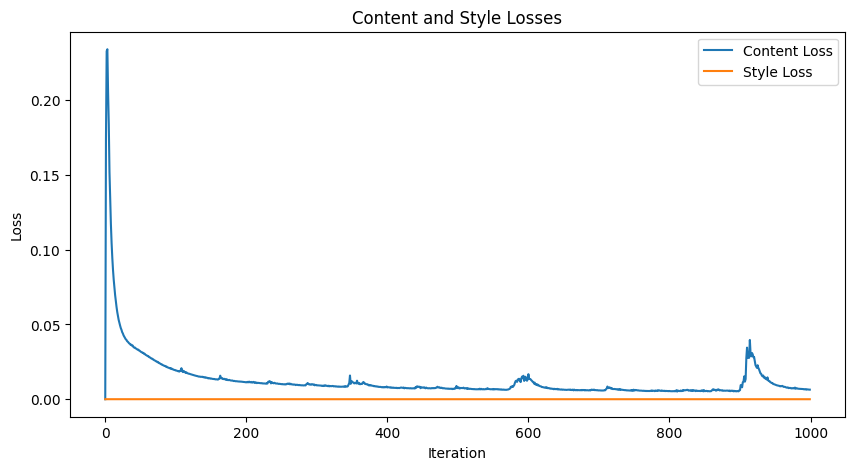

In [2]:
import matplotlib.pyplot as plt

# Plot loss graph
plt.figure(figsize=(10, 5))
plt.plot(range(len(content_losses)), content_losses, label='Content Loss')
plt.plot(range(len(style_losses)), style_losses, label='Style Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Content and Style Losses')
plt.legend()
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


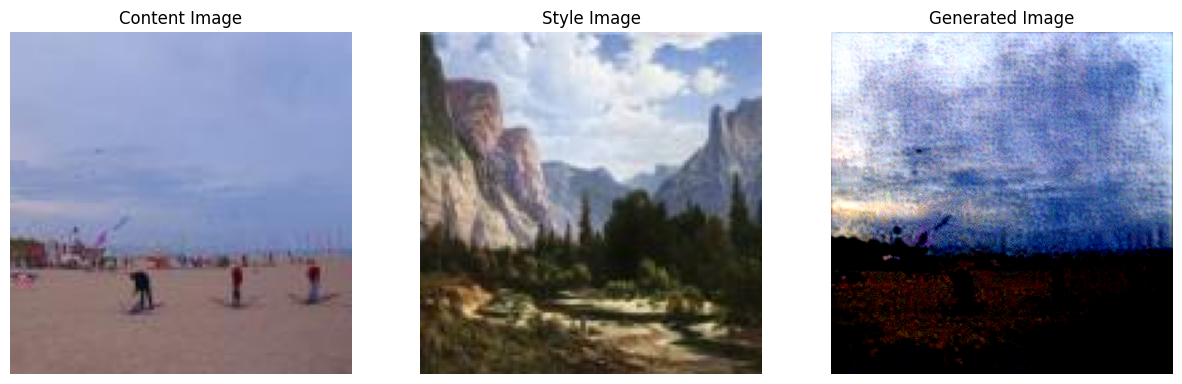

In [3]:
import matplotlib.pyplot as plt

# Load images
content_image = Image.open(content_image_path)
style_image = Image.open(style_image_path)
generated_image = output_image.squeeze(0).cpu().detach().permute(1, 2, 0).numpy()

# Resize style image to match the dimensions of content and generated images
style_image = style_image.resize(content_image.size)

# Plot images
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(content_image)
plt.title('Content Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(style_image)
plt.title('Style Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(generated_image)
plt.title('Generated Image')
plt.axis('off')

plt.show()
